# Overview 

In the first ~1/3 of this lecture, we will review homework, programming, and fMRI concepts

In the second ~1/3 of this lecture, we will introduce data normalization and logical indexing

In the last ~1/3 of this lecture we will introduce software to display fMRI data on a 3D representation of the cortical surface.

# Goals
* Understand the way pycortex represents a volumetric data set
* Create pycortex Volume objects from 3D data, masked data, and time series data
* Display data on the cortical surface



# Updating resources in your server home directory
(Run the cells in this section once, then restart your kernel and skip these sections!)

In [ ]:
# Updating functions
import neurods
import cortex as cx
# Add figures to notebook
dropbox_link = ''
neurods.io.download_file(dropbox_link, '')  ## FIX ME
# Update neurods package
neurods.io.update_neurods()
# Update pycortex configuration file
cx.config.set('basic', 'filestore', '/data/shared/cogneuro88/pycortex_store/')
with open(cx.options.usercfg, 'w') as fid:
    cx.config.write(fid)

# Part 1:  Writing reusable functions
& misc. code / efficiency tips!

In [1]:
# Load some necessary libraries
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Set plotting defaults
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
# Teacher notes
plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.aspect'] = 'equal'

In [4]:
# Teacher notes
# Make note of hotkeys here!

We created the following functions to make plots of slices of fMRI volumes. In some code libraries, these are called light table or mosaic plots, because in the (literally) dark old days of film photography, photographers used to lay out their film negatives on light tables in a format similar to this to see them.

We will want to make plots like this many times throughout the course, so we would like to formalize these functions a little more to make them more readily reusable. 

In [5]:
def get_any_slice(volume, slice_number, dimension):
    """Given an integer and a 3D volume, this function returns the data of 
    that horizontal slice """ 
    if dimension == 0:
        img = volume[slice_number, :, :]
    elif dimension == 1:
        img = volume[:, slice_number, :]
    elif dimension == 2:
        img = volume[:, :, slice_number]
    return img

def plot_any_slice_v2(volume, slice_number, dimension, cmap = 'viridis', vmin=0, vmax=2000,
                     origin = 'lower', interpolation='nearest', aspect='equal'):
    img = get_any_slice( volume, slice_number, dimension)
    _ = plt.imshow(img, cmap = cmap, vmin= vmin, vmax = vmax, origin = origin, interpolation = interpolation,
                  aspect = aspect)
    _ = plt.axis('off')
    
def plot_all_slices(volume, slice_dimension, nrows, ncols , cmap = 'viridis', vmin=0, vmax=2000,
                     origin = 'lower', interpolation='nearest', aspect='equal' ):
    fig = plt.figure(figsize = (8,8))
    n_slices = first_volume.shape[slice_dimension]
    for s in range(n_slices):
        ax = fig.add_subplot(nrows, ncols, s+1)
        plot_any_slice_v2(first_volume, s, slice_dimension, cmap = cmap, vmin= vmin, vmax = vmax, 
                          origin = origin, interpolation = interpolation,aspect = aspect)    

We will modify the final function to be more production-ready below. Follow along...

* One major addition we need to make is a ***docstring***. See [here](https://github.com/numpy/numpy/blob/master/doc/HOWTO_DOCUMENT.rst.txt#docstring-standard) for a general description of writing docstrings according to the numpy format, and [here](https://github.com/numpy/numpy/blob/master/doc/example.py) for clear examples.
* We will use the `**kwargs` syntax to pass keyword arguments from function to function
* We will modify argument names to be more similar to arguments in similar functions

In [54]:
# Teacher info
def slice_3d_array(volume, axis, nrows, ncols , vmin=0, vmax=2000, 
                   figsize=(8,8), slice_prefix=None, **kwargs):
    """Plot slices of 3D array along an arbitrary axis
    
    Parameters
    ----------
    volume : array
        3D array to be plotted
    axis : int
        dimension to be sliced / plotted
    nrows, ncols : int
        number of rows / columns in plot
    vmin, vmax : scalar
        miniumum / maximum value for color scale all plots
    figsize : tuple
        (X, Y) size in inches for figure
    slice_prefix : string or None
        If provided as a string, this is a format string for titles of each
        individual plot (titles will be `slice_prefix.format(slice_number)`)
        if None, no titles are added
    Other Parameters
    ----------------
    kwargs : named keyword arguments
        keyword arguments are passed to imshow()
    
    """
    fig = plt.figure(figsize = figsize)
    n_slices = volume.shape[axis]
    for s in range(n_slices):
        ax = fig.add_subplot(nrows, ncols, s+1)
        img = get_any_slice(volume, s, axis)
        ax.imshow(img, vmin = vmin, vmax = vmax, **kwargs)
        if slice_prefix is not None:
            ax.set_title(slice_prefix.format(s))
        ax.set_axis_off()
    plt.tight_layout()

In [33]:
import neurods
neurods.viz.slice_3d_array?

## Survey 1!

In [ ]:
# Teacher info
https://docs.google.com/a/berkeley.edu/forms/d/e/1FAIpQLSfzF7dZ3z2GI8TzrnImXeXf0qIyDmUof8XuB97j0aZ1UyK-mg/viewform

# Load data
Today, we will load data from a common neuroimaging data format ([NIfTI](https://nifti.nimh.nih.gov/nifti-1/) format). If you find open source neuroimaging data online, it will most likely be in this format. To load this data, we need to use a neuroimaging code library called nibabel. 

In [7]:
import nibabel
import os

In [8]:
# Create a nifti (nii) proxy object
fbase = '/Users/mark/Dropbox/data8/' #'/data/shared/cogneuro88'
fname = os.path.join(fbase,'fMRI/categories/s01_categories_01.nii.gz')
nii = nibabel.load(fname) 

# This object stores the infomation *about* the fMRI data stored in the file. 
# This meta-data can be accessed via attributes of the `nii` object.
print('nii.in_memory :', nii.in_memory)
print('nii.shape :', nii.shape)
print('voxel sizes :', nii.header.get_zooms())

nii.in_memory : False
nii.shape : (100, 100, 30, 120)
voxel sizes : (2.24, 2.24, 4.1300001, 1.0)


There is also information stored about how the brain was oriented in space as it was scanned, but that is beyond the scope of what we will go into here. 

In [9]:
# Retrieve actual data as an array
data = nii.get_data().T
print('nii.in_memory : ', nii.in_memory)
print('data shape : ', data.shape)

nii.in_memory :  True
data shape :  (120, 30, 100, 100)


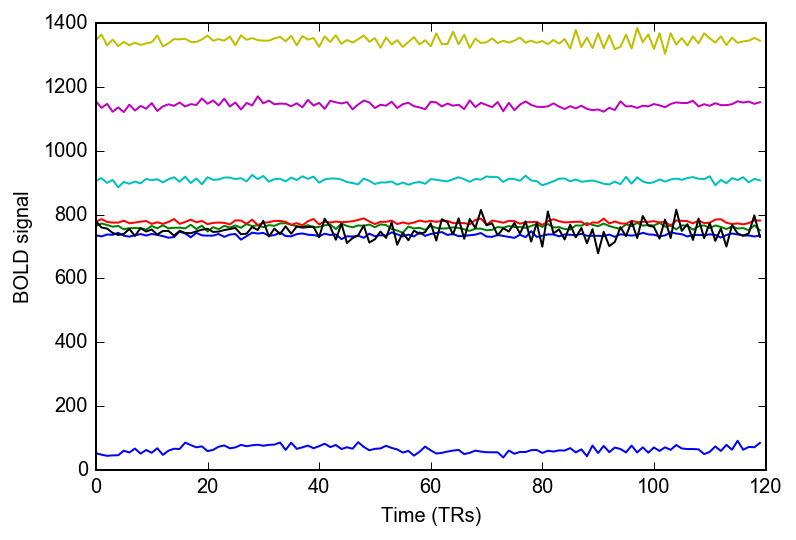

In [10]:
# Plot a few voxels
_ = plt.plot(data[:,22:, 45, 45])
_ = plt.xlabel('Time (TRs)')
_ = plt.ylabel('BOLD signal')

### HW Recap

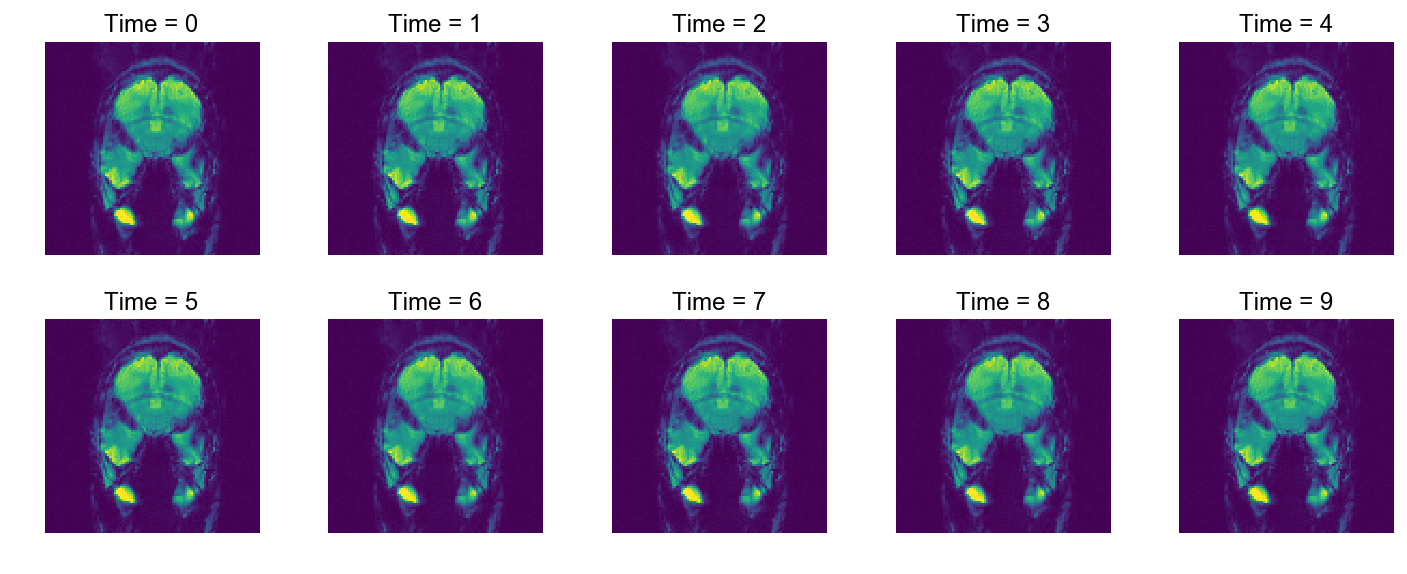

In [11]:
# Plot an image of the first 10 time points for all voxels in one horizontal slice
slice_3d_array(data[:10,5], 0, 2, 5, slice_prefix='Time = {}', figsize=(10,4), vmin=0, vmax=1000)

### BREAKOUT SESSION
Make an image plot of all the voxels in one horizonatal slice. 

1. Select all time points for one horizontal slice
2. Use np.reshape make a 2D array that is (time x voxels) 
3. Use `plt.imshow` to show that 2D array
4. Make the plot pretty! (label axes, set an appropriate color scale, etc)

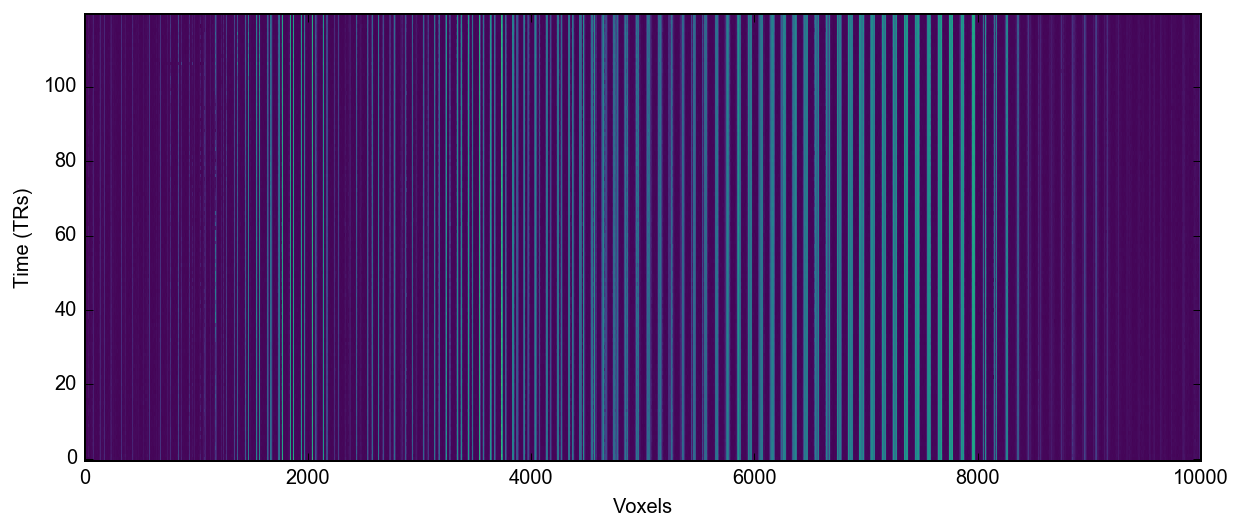

In [13]:
### STUDENT ANSWER
plt.figure(figsize=(10,4))
to_show = data[:, 5].reshape(120, 100*100)
plt.imshow(to_show, aspect='auto')
plt.xlabel('Voxels')
plt.ylabel('Time (TRs)');

The plot you make should show clearly that the problem is that there's more variability across voxels than there is across time (Some voxels *always* show higher signal than others). This scaling issue complicates some kinds of visualization and analysis. To look at this issue a slightly different way, let's look at histograms of the timecourses for two voxels.

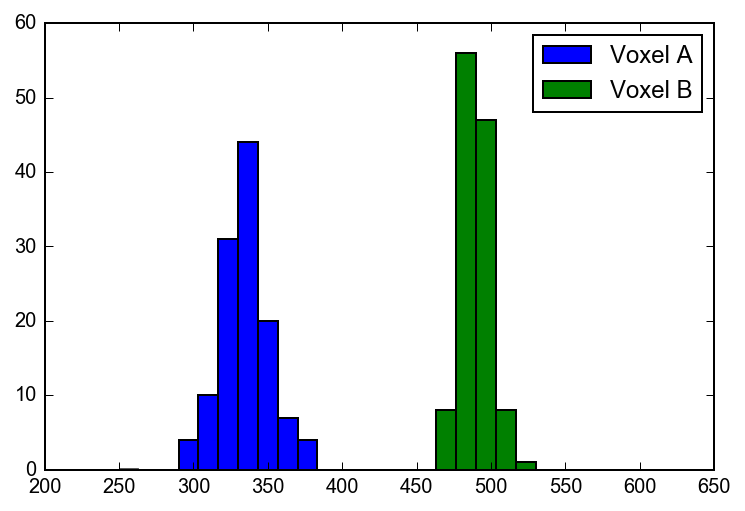

In [17]:
bins = np.linspace(250, 650, 31)
voxel_a = data[:, 5, 50, 43]
voxel_b = data[:, 5, 50, 53]
_ = plt.hist(voxel_a, bins, label='Voxel A')
_ = plt.hist(voxel_b, bins, label='Voxel B')
plt.legend()

## Survey 2!

In [15]:
def minmax_norm(data):
    """Normalize data to range of 0-1 by subtracting min, dividing by range"""
    data_norm = (data-data.min()) / (data.max()-data.min())
    return data_norm

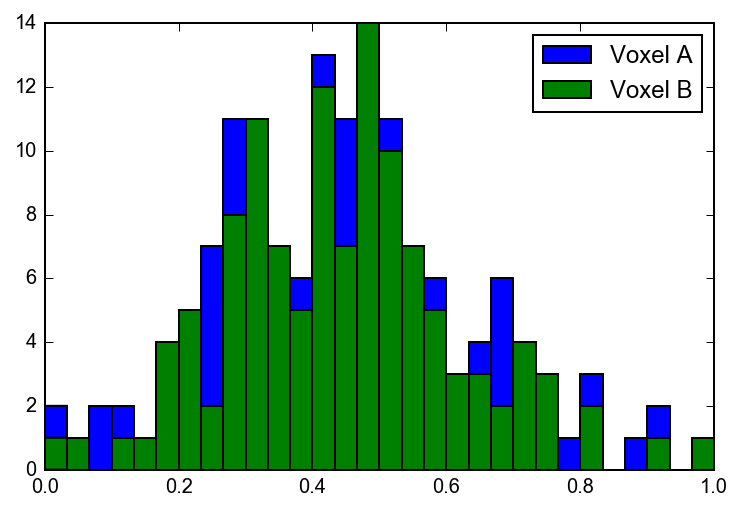

In [18]:
bins01 = np.linspace(0,1,31)
voxel_a_n = minmax_norm(voxel_a)
voxel_b_n = minmax_norm(voxel_b)
_ = plt.hist(voxel_a_n, bins01, label='Voxel A')
_ = plt.hist(voxel_b_n, bins01, label='Voxel B')
plt.legend()

Looks sensible. However, a problem with this normalization method shows up when you have outlying values. What would happen if Voxel A, at one time point, had a (spuriously) very large value? Let's see!

In [19]:
# Aside: a cautionary tale. Python memory is weird.
a = np.arange(10)
b = a
b[3] = 63
print(a)

[ 0  1  2 63  4  5  6  7  8  9]


In [20]:
# You can avoid changing a variable by using the copy package
import copy
a = np.arange(10)
b = copy.copy(a)
b[3] = 63
print(a)

[0 1 2 3 4 5 6 7 8 9]


In [27]:
# Create a variable called voxel_a_wonky and add an outlier to it
voxel_a_wonky = copy.copy(voxel_a)
voxel_a_wonky[5] = voxel_a_wonky.max()*1.5

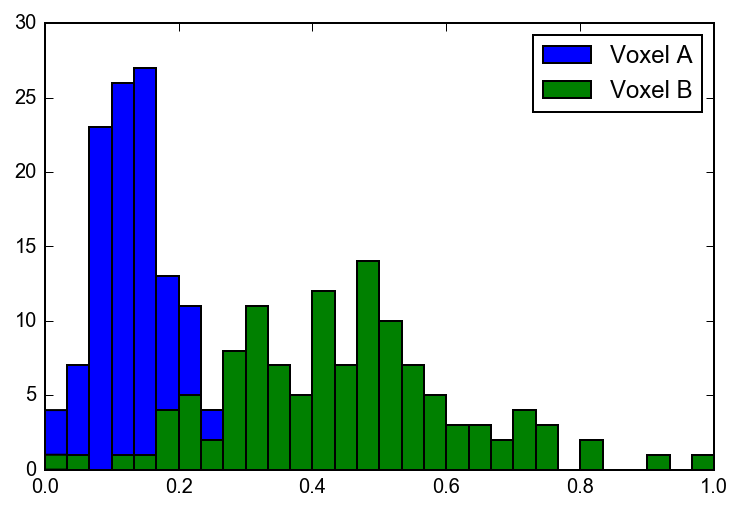

In [28]:
# See what that outlier does to histogram plots created after our first normalization method!
_ = plt.hist(minmax_norm(voxel_a_wonky), bins01, label='Voxel A')
_ = plt.hist(minmax_norm(voxel_b), bins01, label='Voxel B')
plt.legend()

A more robust, stable way to normalize data is to subtract the *mean* of the data instead of the min, and to divide by the *standard deviation* instead of the range. 

In [ ]:
# Teacher info
# White board explanation of standard deviation

In [29]:
# You can compute the standard deviation of 
voxel_a.std(), voxel_b.std()

(16.850417605706298, 9.0005450607626099)

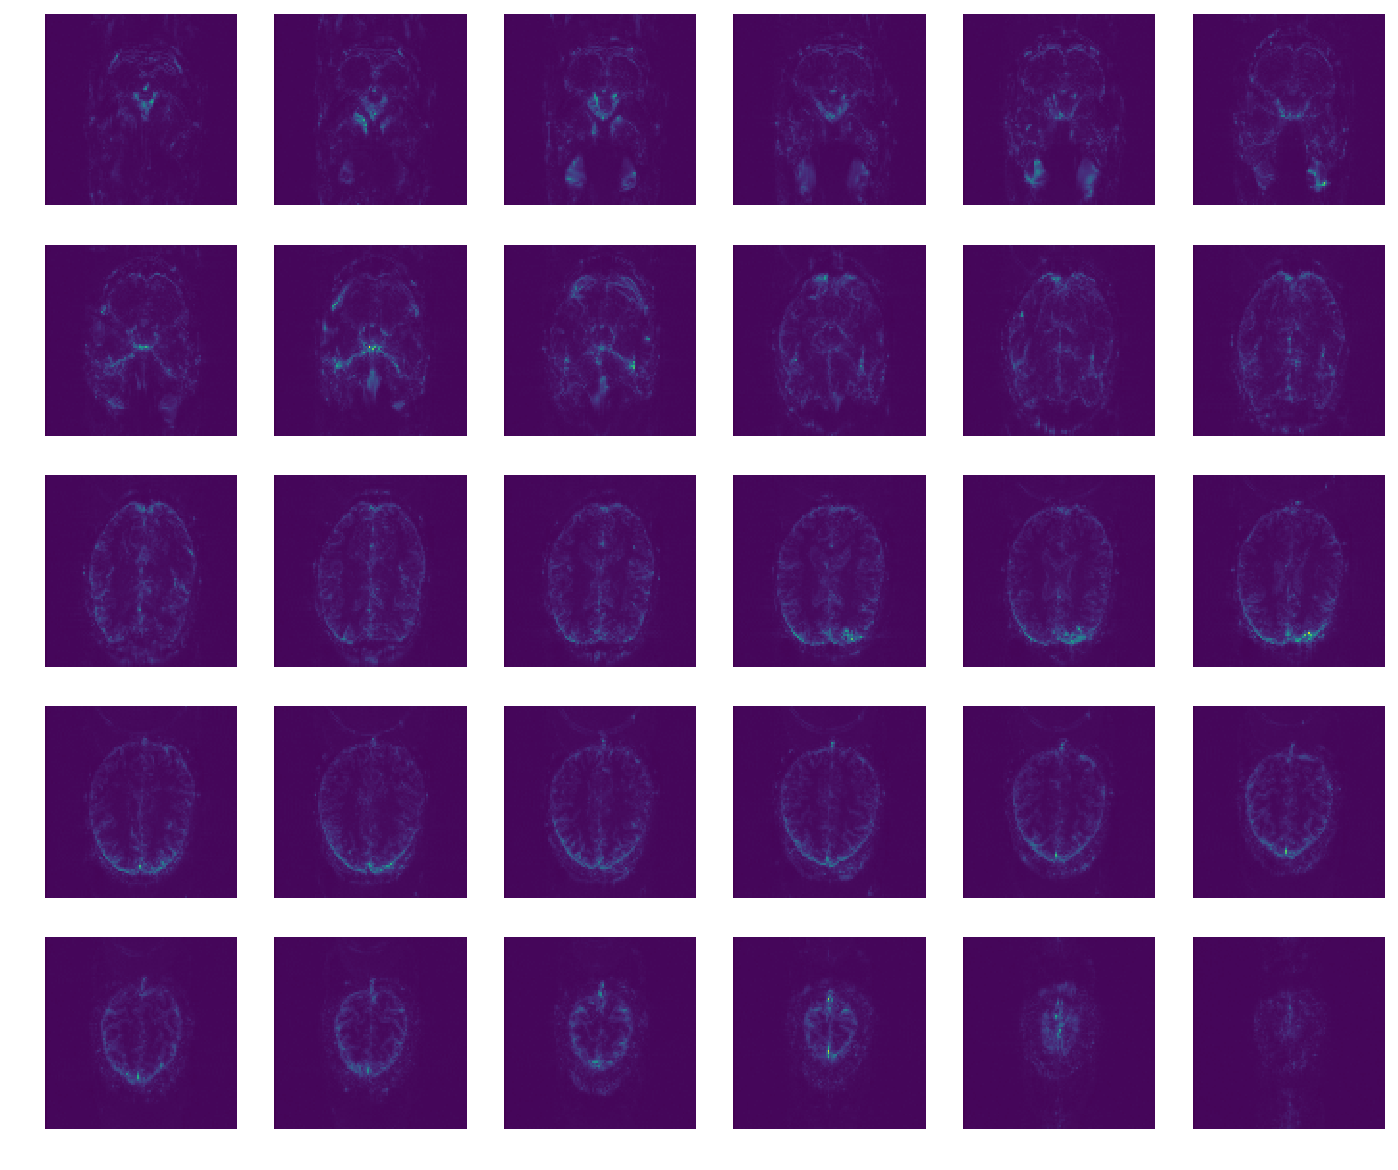

In [58]:
# We can look at the standard deviation of the data by slice
slice_3d_array(data.std(axis=0), 0, 5, 6)
#slice_3d_array(data.std(axis=0), 0, 5, 6, vmin=0, vmax=200, figsize=(6*2,5*2))
#_ = neurods.viz.slice_3d_array(data.std(axis=0), axis=0)

### Breakout session
Perform normalization of Voxel A and Voxel B by (1) subtracting off the mean (**`array.mean()`** or **`np.mean(array)`**) and (2) dividing by the standard deviation (**`array.std()`** or **`np.std(array)`**)

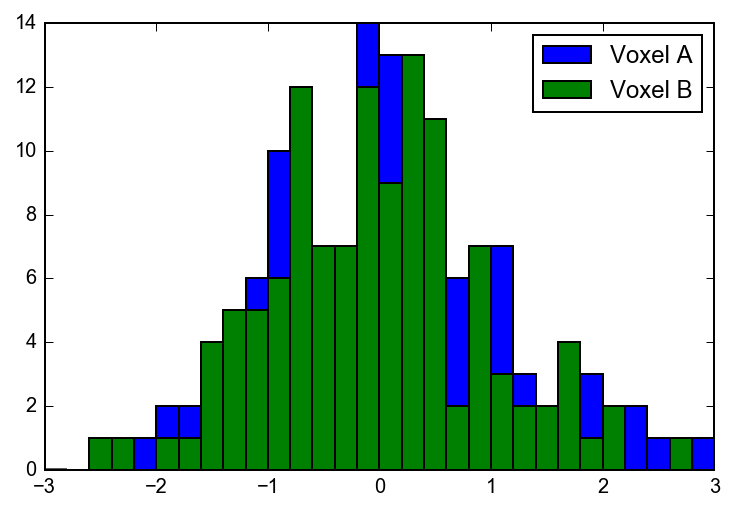

In [31]:
### STUDENT ANSWER

def znorm(data):
    data_norm = (data-data.mean()) / data.std()
    return data_norm
binsz = np.linspace(-3,3,31)
_ = plt.hist(znorm(voxel_a), binsz, label='Voxel A')
_ = plt.hist(znorm(voxel_b), binsz, label='Voxel B')
plt.legend()

In [40]:
from scipy.stats import zscore

In [ ]:
# zscoring can be done with 

In [41]:
data_z = zscore(data, axis=0)

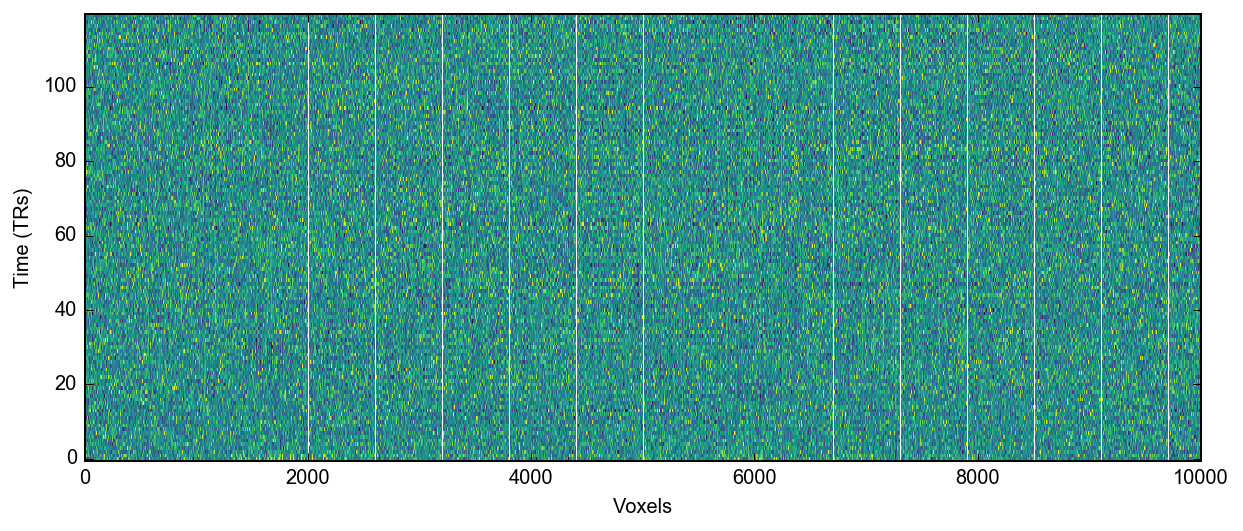

In [43]:
plt.figure(figsize=(10,4))
plt.imshow(data_z[:, 5].reshape(120, 100*100), aspect='auto', vmin=-3, vmax=3)
plt.xlabel('Voxels')
plt.ylabel('Time (TRs)')

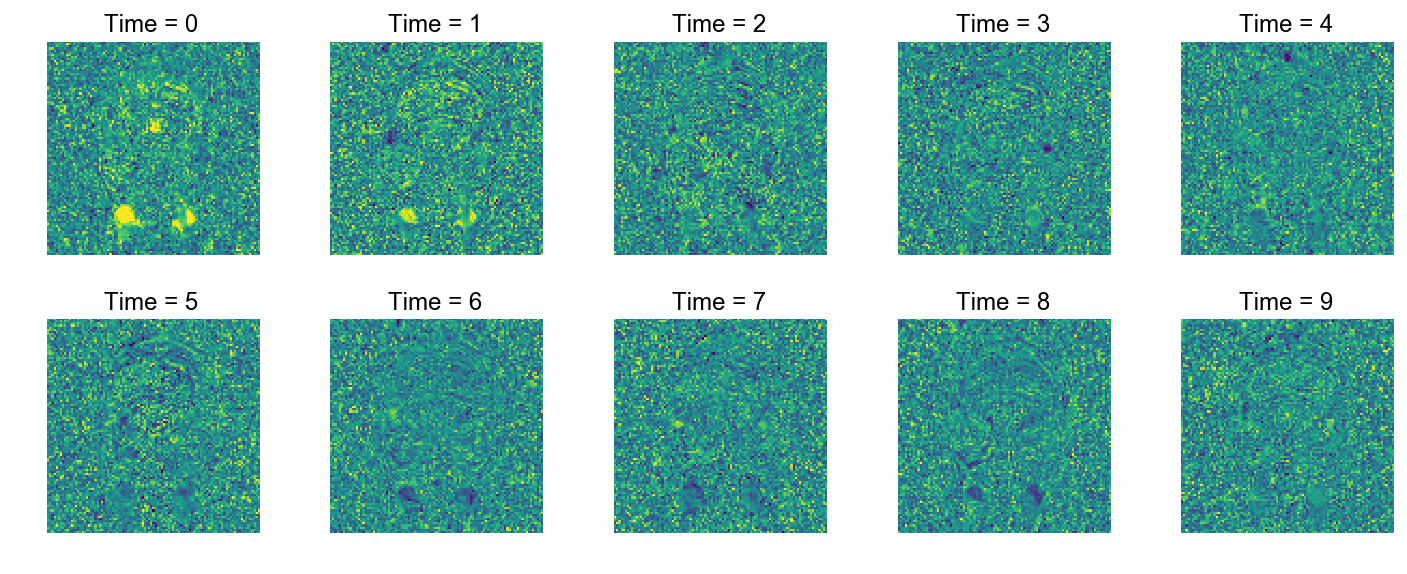

In [49]:
slice_3d_array(data_z[:10,5], 0, 2, 5, slice_prefix='Time = {}', figsize=(10,4), vmin=-3, vmax=3)

# Onward to 3D data visualizations! 

We will use a python module called **`pycortex`** to show data in 3D on the brain. This module was developed here at UC Berkeley in the Gallant lab, mostly by James Gao, with help from Alex Huth, Mark Lescroart, and other lab members. The code is freely available online [here](https://github.com/gallantlab/pycortex), and a paper summarizing the code can be found [here](http://journal.frontiersin.org/article/10.3389/fninf.2015.00023/full). 

To map the functional data onto the cortex, pycortex requires at least two things:

1. The cortical surface of the subject. 
    * pycortex stores cortical surface files (and several other files) for each subject in a reliably structured directory of files. Because of this reliable directory structure, all we need to provide to the code is a subject ID string, and the code will be able to find and load the relevant cortical surface files. 
2. The functional to anatomical aligmnent of this data to that cortical surface
    * Alignment of functional data to anatomical data proceeds by an *affine transform*. How this transformation works is beyond the scope of this class, but you can look it up on [wikipedia](https://en.wikipedia.org/wiki/Affine_transformation) or in your favorite linear algebra textbook if you're curious. The practical upshot is that a 4x4 matrix of numbers is sufficient to store the 3 rotations (around the x, y, and z axes) and 3 the transformations (in the x, y and z dimensions) that will transform the functional data in space such that they are aligned with the anatomical data (with the cortical surface). In the pycortex code (and in other neuroimaging software), "transform" is abbreviated in variable names as `xfm`. Just as with the cortical surface, we only need to specify a name for a transform, and the code will know where to find the file that contains the affine transformation matrix. 

In [ ]:
import cortex

In [ ]:
# (1) subject (specifies the cortical surface of the brain)
subject = 'S2' 
# (2) transform = functional-to-anatomical alignment
transform = 'S2_category_auto' 

In [ ]:
# Create a volume
data_volume = cortex.Volume(data[0], subject, transform) 

In [ ]:
# Show the volume in a 3D brain (ooooh)
cortex.webgl.show(data_volume)

In [ ]:
cortex.quickflat.make_figure(data_volume)